In [101]:
"""
Wildfire perimeters:
- Filter wildfire perimeters from FIRED (2018-2023)
- Calculate the LANDFIRE EVT (ca. 2016) categorical percentages
- Filter for wildfires where aspen cover >= 5%

Fire Radiative Power (FRP):
Read in the archived FRP data from the SUOMI VIIRS C2 (375m Obs.) as shapefile for the western U.S. (2018-2023)
Downloaded for western US from the LAADS archive: https://firms.modaps.eosdis.nasa.gov/download/
"""

import os, time
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib
import matplotlib.pyplot as plt

from rasterstats import zonal_stats

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'

print("Complete")

Complete


## Wrangle the wildfire data

First, we need to identify wildfire events across the western U.S. which had at least 5% pre-fire aspen cover. We start with a database of FIRED events extracted to western US states. We then calculate the zonal histogram from the LANDFIRE EVT (ca. 2016 remap). From there, we can identify wildfires with >5% aspen cover.

In [16]:
# Load the FIRED perimeters (2018-2022)
fired_path = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_west.gpkg')
fired = gpd.read_file(fired_path).to_crs(proj)
fired['ig_year'] = fired['ig_year'].astype(int)
fired = fired[(fired['ig_year'] >= 2018) & (fired['ig_year'] <= 2023)]
print(fired['ig_year'].describe())
fired = fired.rename(columns={'id': 'fired_id'})
fired['fired_id'] = fired['fired_id'].astype(str)

print(len(fired['fired_id'].unique()))

count    8703.000000
mean     2020.438125
std         1.640964
min      2018.000000
25%      2019.000000
50%      2021.000000
75%      2022.000000
max      2023.000000
Name: ig_year, dtype: float64
8703


In [17]:
# Load the LANDFIRE EVT (ca. 2016)
evt_path = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/Tif/LC16_EVT_200.tif')
evt = rxr.open_rasterio(evt_path, masked=True).squeeze()
shp, gt, wkt, nd = evt.shape, evt.spatial_ref.GeoTransform, evt.rio.crs, evt.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {evt[0].dtype}")

Shape: (97283, 154207); 
GeoTransform: -2362425.0 30.0 0.0 3177435.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


In [18]:
# Calculate the percent cover of forest types from the LANDFIRE EVT
begin = time.time()
zs = zonal_stats(vectors=fired[['fired_id','geometry']], raster=evt_path, categorical=True, geojson_out=True)
print(f"Total elapsed time: {round((time.time() - begin))} seconds.")

Total elapsed time: 80 seconds.


In [29]:
stats = gpd.GeoDataFrame(zs).fillna(0) #One column per raster category, and pixel count as value
print(stats.head())
print(len(stats['id'].unique()))

   id     type                                         properties  \
0   6  Feature  {'fired_id': '10.0', 7035: 1, 7037: 99, 7039: ...   
1   9  Feature  {'fired_id': '13.0', 7035: 8, 7036: 5, 7037: 9...   
2  11  Feature  {'fired_id': '15.0', 7037: 80, 7039: 141, 7043...   
3  14  Feature  {'fired_id': '18.0', 7036: 411, 7037: 7, 7039:...   
4  15  Feature  {'fired_id': '19.0', 7008: 4, 7037: 60, 7039: ...   

                                            geometry  \
0  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
1  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
2  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
3  {'type': 'MultiPolygon', 'coordinates': [(((-2...   
4  {'type': 'MultiPolygon', 'coordinates': [(((-2...   

                                                bbox  
0  (-2204367.7411383186, 2575991.303125085, -2203...  
1  (-2218189.4634304265, 2575287.98777307, -22172...  
2  (-2221181.6184710716, 2572788.3472813824, -222...  
3  (-2259652.382685736, 2575

In [30]:
# Explore the properties json

# First get the fired_id
stats['fired_id'] = stats['properties'].apply(lambda x: x.get('fired_id'))
print(stats['fired_id'])

# Retrieve the other properties (EVT codes)
stats['properties'] = stats['properties'].apply(lambda x: {key: val for key, val in x.items() if key != 'fired_id'})
stats['properties_list'] = stats['properties'].apply(lambda x: list(x.items()))

# Explode the json
props = stats.explode('properties_list').reset_index(drop=True)

# retrieve the list items as new columns
props[['EVT', 'pixel_count']] = pd.DataFrame(props['properties_list'].tolist(), index=props.index)
props = props[['fired_id','EVT','pixel_count']].reset_index(drop=True)

# Calculate the percent of each class
total_pixels = props.groupby(props['fired_id'])['pixel_count'].transform('sum')
props['total_pixels'] = total_pixels
props['pct_cover'] = (props['pixel_count'] / props['total_pixels']) * 100

print(props)

print(len(props['fired_id'].unique()))
print(props.columns)

0           10.0
1           13.0
2           15.0
3           18.0
4           19.0
          ...   
8698    188702.0
8699    188703.0
8700    188771.0
8701    189388.0
8702    189402.0
Name: fired_id, Length: 8703, dtype: object
        fired_id   EVT  pixel_count  total_pixels  pct_cover
0           10.0  7035            1           242   0.413223
1           10.0  7037           99           242  40.909091
2           10.0  7039           81           242  33.471074
3           10.0  7043           54           242  22.314050
4           10.0  7063            2           242   0.826446
...          ...   ...          ...           ...        ...
122100  189402.0  9513           13         19182   0.067772
122101  189402.0  9514          578         19182   3.013242
122102  189402.0  9515           33         19182   0.172036
122103  189402.0  9516          497         19182   2.590971
122104  189402.0  9816          534         19182   2.783860

[122105 rows x 5 columns]
8703
Index

In [31]:
# Read in the lookup table for the EVT codes
lookup = os.path.join(maindir,'data/landcover/LANDFIRE/LF2016_EVT_200_CONUS/CSV_Data/LF16_EVT_200.csv')
lookup = pd.read_csv(lookup)
print(lookup.columns)

Index(['VALUE', 'EVT_NAME', 'LFRDB', 'EVT_FUEL', 'EVT_FUEL_N', 'EVT_LF',
       'EVT_PHYS', 'EVT_GP', 'EVT_GP_N', 'SAF_SRM', 'EVT_ORDER', 'EVT_CLASS',
       'EVT_SBCLS', 'R', 'G', 'B', 'RED', 'GREEN', 'BLUE'],
      dtype='object')


In [32]:
### Subset the codes we want to join, join back to the dataframe
lookup = lookup[['VALUE','EVT_NAME','EVT_PHYS','EVT_GP_N','EVT_CLASS']]
props_df = props.merge(lookup, left_on='EVT', right_on='VALUE', how='left')
print(props_df.head())
print(len(props_df['fired_id'].unique()))

  fired_id   EVT  pixel_count  total_pixels  pct_cover  VALUE  \
0     10.0  7035            1           242   0.413223   7035   
1     10.0  7037           99           242  40.909091   7037   
2     10.0  7039           81           242  33.471074   7039   
3     10.0  7043           54           242  22.314050   7043   
4     10.0  7063            2           242   0.826446   7063   

                                            EVT_NAME  EVT_PHYS  \
0  North Pacific Dry Douglas-fir-(Madrone) Forest...   Conifer   
1  North Pacific Maritime Dry-Mesic Douglas-fir-W...   Conifer   
2  North Pacific Maritime Mesic-Wet Douglas-fir-W...   Conifer   
3    Mediterranean California Mixed Evergreen Forest   Conifer   
4           North Pacific Broadleaf Landslide Forest  Hardwood   

                                          EVT_GP_N           EVT_CLASS  
0                  Douglas-fir Forest and Woodland  Closed tree canopy  
1  Douglas-fir-Western Hemlock Forest and Woodland  Closed tree ca

In [34]:
# Identify classes with 'aspen' in the EVT_NAME
aspen_evt = props_df[props_df['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(aspen_evt)

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']


In [39]:
# Now filter to retain wildfire events with at least 5% aspen forest cover
props_filtered = props_df[props_df['EVT_NAME'].isin(aspen_evt)]
aspen_sum = aspen_df.groupby('fired_id')['pct_cover'].sum().reset_index() # get the sum of aspen classes
aspen_sum['pct_aspen'] = aspen_sum['pct_cover']  # rename the column to retain aspen percent
aspen_fires = aspen_sum[aspen_sum['pct_cover'] >= 5] # retain fires with >= 5% 
aspen_fires = aspen_fires[['fired_id','pct_aspen']]
aspen_df = pd.merge(aspen_fires, props_df, on='fired_id', how='inner')
aspen_df = aspen_df.drop(['VALUE'], axis=1)
print(aspen_df)

      fired_id  pct_aspen   EVT  pixel_count  total_pixels  pct_cover  \
0     188020.0  11.475541  7011         1203         49941   2.408842   
1     188020.0  11.475541  7012          173         49941   0.346409   
2     188020.0  11.475541  7016        11612         49941  23.251437   
3     188020.0  11.475541  7019          513         49941   1.027212   
4     188020.0  11.475541  7020          482         49941   0.965139   
...        ...        ...   ...          ...           ...        ...   
8027   81539.0   6.261520  9019           18         18446   0.097582   
8028   81539.0   6.261520  9021           76         18446   0.412013   
8029   81539.0   6.261520  9022          975         18446   5.285699   
8030   81539.0   6.261520  9328            9         18446   0.048791   
8031   81539.0   6.261520  9828           33         18446   0.178901   

                                               EVT_NAME           EVT_PHYS  \
0              Rocky Mountain Aspen Forest an

In [41]:
print(len(aspen_df['fired_id'].unique()))
aspen_sum_5pct = aspen_sum[aspen_sum['pct_cover'] >= 5]
aspen_sum_5pct

405


,fired_id,pct_cover,pct_aspen
11,188020.0,11.475541,11.475541
16,188104.0,15.554384,15.554384
17,188109.0,10.328717,10.328717
18,188111.0,21.050049,21.050049
20,188113.0,38.313856,38.313856
...,...,...,...
1271,80852.0,24.608150,24.608150
1272,80857.0,7.935393,7.935393
1273,80864.0,10.354413,10.354413
1277,81515.0,7.802875,7.802875


In [54]:
# Join back to the FIRED data

# Check for matching fired_id set
common_ids = set(fired['fired_id']).intersection(set(aspen_df['fired_id'])) # Find intersection
print(f"Number of common IDs: {len(common_ids)}")

# Join the attribute data to FIRED polygons
fired['fired_id'] = fired['fired_id'].astype(str)
aspen_df['fired_id'] = aspen_df['fired_id'].astype(str)

fired_aspen = pd.merge(fired, aspen_df, on='fired_id', how='inner')
print(len(fired_aspen['fired_id'].unique()))

Number of common IDs: 405
405


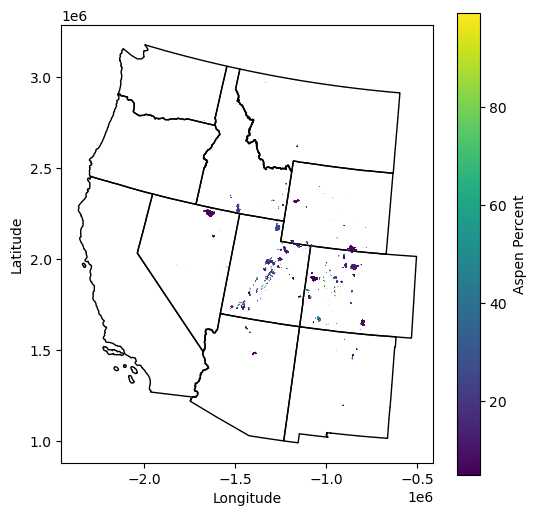

In [69]:
# Spatial map of aspen wildfires
# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))

# Plot using a viridis color scale based on 'aspen_percent'
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')
fired_aspen.plot(column='pct_aspen', ax=ax, legend=True,
                 legend_kwds={'label': "Aspen Percent"},
                 cmap='viridis', edgecolor='none')

# Optional enhancements
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
plt.show()


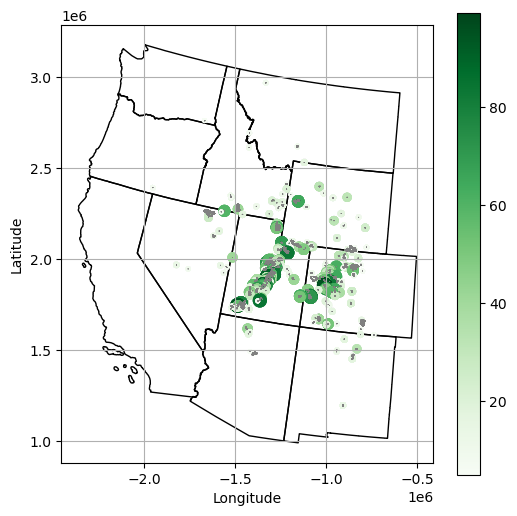

In [66]:
centroid = fired_aspen.copy()
centroid['geometry'] = centroid.geometry.centroid

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Plot centroids
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary
centroid.plot(ax=ax, markersize=centroid['pct_aspen'], column='pct_aspen', cmap='Greens', legend=True, alpha=0.6)

# Optional: Plot the original fire perimeters for context
fired_aspen.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

## Wrangle the VIIRS 375m Active Fire Data

First, load the raw VIIRS observations (shapefile). Then extract VIIRS observations within FIRED perimeters with 5% aspen cover.

In [73]:
# Load the VIIRS archive shapefile
frp = os.path.join(maindir,'aspen-fire/Aim2/data/spatial/raw/VIIRS/DL_FIRE_SV-C2_438955/fire_archive_SV-C2_438955.shp')
frp = gpd.read_file(frp).to_crs(proj)
print(frp.head())
print(frp.columns)

,LATITUDE,LONGITUDE,BRIGHTNESS,SCAN,TRACK,ACQ_DATE,ACQ_TIME,SATELLITE,INSTRUMENT,CONFIDENCE,VERSION,BRIGHT_T31,FRP,DAYNIGHT,TYPE,geometry
0,36.622398,-119.958420,319.25,0.45,0.63,2018-01-01,0854,N,VIIRS,n,1,276.46,1.93,N,0,POINT (-2100437.814 1774627.392)
1,52.459568,-111.630615,323.05,0.48,0.48,2018-01-01,0854,N,VIIRS,n,1,243.43,3.18,N,0,POINT (-1091116.265 3354944.086)
2,44.249660,-104.516678,327.49,0.38,0.36,2018-01-01,0854,N,VIIRS,n,1,251.79,5.84,N,0,POINT (-677212.174 2392519.636)
3,44.235138,-104.511192,340.10,0.38,0.36,2018-01-01,0854,N,VIIRS,n,1,254.04,7.23,N,0,POINT (-676921.891 2390868.377)
4,44.037102,-107.041763,342.43,0.41,0.37,2018-01-01,0854,N,VIIRS,n,1,256.44,8.82,N,0,POINT (-879943.440 2389634.298)


In [81]:
# Extract VIIRS obs. within aspen fires (1km buffer)

# Buffer the fires by 1km
fired_aspen_1km = fired_aspen.copy()
fired_aspen_1km['geometry'] = fired_aspen_1km.geometry.buffer(1000)

# Extract VIIRS obs.
frp_aspen = gpd.sjoin(frp, fired_aspen_1km, how='inner', predicate='within')
# print(frp_aspen.columns)

frp_aspen = frp_aspen[[
    'LATITUDE', 'LONGITUDE', 'ACQ_DATE', 'ACQ_TIME', 'CONFIDENCE', 
    'FRP', 'DAYNIGHT', 'fired_id', 'ig_date', 'ig_day', 'ig_month', 
    'ig_year', 'last_date', 'event_dur', 'tot_ar_km2', 'fsr_km2_dy',
    'mx_grw_km2', 'mn_grw_km2','mu_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
    'eco_mode', 'eco_name', 'tot_perim', 'pct_aspen', 'EVT',
    'pixel_count', 'total_pixels', 'pct_cover', 'EVT_NAME', 'EVT_PHYS',
    'EVT_GP_N', 'EVT_CLASS', 'geometry']]
frp_aspen.head()

,LATITUDE,LONGITUDE,ACQ_DATE,ACQ_TIME,CONFIDENCE,FRP,DAYNIGHT,fired_id,ig_date,ig_day,...,pct_aspen,EVT,pixel_count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS,geometry
805,37.512726,-112.719727,2018-01-10,0930,n,1.79,N,48428.0,2020-11-16 00:00:00,321,...,8.981698,7011,1204,26554,4.534157,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,POINT (-1456371.520 1736657.723)
851,37.507584,-112.700630,2018-01-11,0906,n,1.41,N,48428.0,2020-11-16 00:00:00,321,...,8.981698,7011,1204,26554,4.534157,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,POINT (-1454825.995 1735797.839)
852,37.506954,-112.695930,2018-01-11,0906,n,1.41,N,48428.0,2020-11-16 00:00:00,321,...,8.981698,7011,1204,26554,4.534157,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,POINT (-1454433.130 1735656.381)
853,37.504143,-112.701294,2018-01-11,0906,n,1.10,N,48428.0,2020-11-16 00:00:00,321,...,8.981698,7011,1204,26554,4.534157,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,POINT (-1454950.665 1735428.311)
854,37.503517,-112.696602,2018-01-11,0906,n,1.10,N,48428.0,2020-11-16 00:00:00,321,...,8.981698,7011,1204,26554,4.534157,Rocky Mountain Aspen Forest and Woodland,Hardwood,"Aspen Forest, Woodland, and Parkland",Open tree canopy,POINT (-1454558.394 1735287.411)


In [82]:
# Only keep nominal and high confidence observations
print(frp['CONFIDENCE'].unique())

# Filter out low confidence observations
frp_aspen = frp_aspen[frp_aspen['CONFIDENCE'] != 'l']

print(len(frp_aspen))

['n' 'h' 'l']
3282285


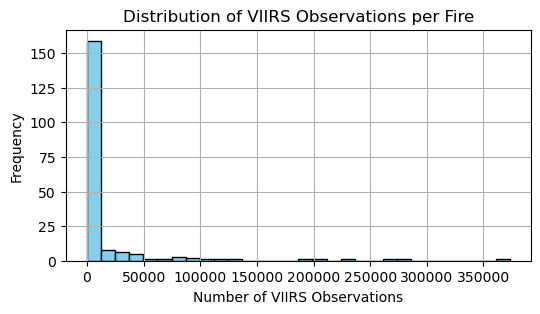

In [84]:
# Get a count of observations per 'fired_id'
viirs_counts = frp_aspen.groupby('fired_id').size().reset_index(name='counts')

# Plot the histogram
plt.figure(figsize=(6, 3))
plt.hist(viirs_counts['counts'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of VIIRS Observations per Fire')
plt.xlabel('Number of VIIRS Observations')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

188325.0
373226


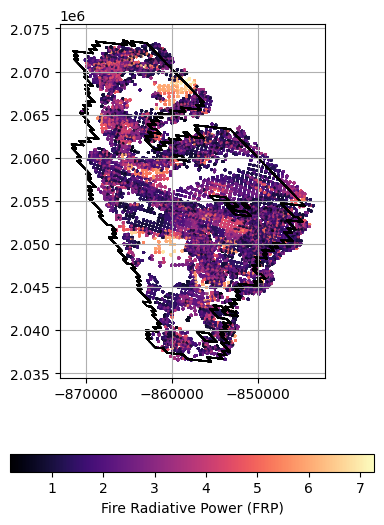

In [108]:
# Make a map of the fire with the most observations

# Sort the VIIRS counts
viirs_counts = viirs_counts.sort_values('counts', ascending=False).reset_index(drop=True)

# Take the first row (the maximum)
max_obs = viirs_counts.iloc[0]['fired_id']
print(max_obs)

# Filter the fire perimeter and VIIRS obs.
perim = fired_aspen[fired_aspen['fired_id'] == max_obs]
obs = frp_aspen[frp_aspen['fired_id'] == max_obs]
obs = obs.copy()
obs['FRP_log'] = np.log1p(obs['FRP'])
print(len(obs))

# Create the map
fig, ax = plt.subplots(figsize=(4, 5.5))
# Plot VIIRS points
obs.plot(column='FRP_log', ax=ax, legend=True,
         legend_kwds={'label': "Fire Radiative Power (FRP)", 'orientation': "horizontal"},
         cmap='magma', markersize=1, alpha=0.7)
# Plot the fire perimeter
perim.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Fire Perimeter')
plt.tight_layout()
plt.grid(True)
plt.show()